In [1]:
"""
Required Libraries: [
    "numpy(1.18.1)",
    "tensorflow(2.1.0)",
    "pandas(1.0.3)",
    "scikit-learn(0.22.2)",
    "PyKomoran(0.1.5)",
    "matplotlib(3.1.3)",
    "graphviz(0.14)",
    "pydot(1.4.1)"
]
"""

'\nRequired Libraries: [\n    "numpy(1.18.1)",\n    "tensorflow(2.1.0)",\n    "pandas(1.0.3)",\n    "scikit-learn(0.22.2)",\n    "PyKomoran(0.1.5)",\n    "matplotlib(3.1.3)",\n    "graphviz(0.14)",\n    "pydot(1.4.1)"\n]\n'

In [2]:
SOT = 'sot'
EOT = 'eot'
PAD = 0

embedding_dim = 256
hidden_size = 1024
encoder_layer_size = 3
learning_late = 0.001
dropout = 0.4

epochs = 50
batch_size = 128

In [3]:
import numpy as np
from typing import List, Tuple, Union

In [5]:
import pickle
import pandas as pd

"""
with open('../crawling/news.pickle', 'rb') as f:
	articles = pickle.load(f)
print(articles.head())
"""
with open('../data/articles.csv', 'r') as f:
	articles = pd.read_csv(f)
print(articles.head())

Unnamed: 0                                              title  \
0           0  House Republicans Fret About Winning Their Hea...   
1           1  Rift Between Officers and Residents as Killing...   
2           2  Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...   
3           3  Among Deaths in 2016, a Heavy Toll in Pop Musi...   
4           4  Kim Jong-un Says North Korea Is Preparing to T...   

                                             summary  
0  The incoming Trump administration could choose...  
1  In the 40th Precinct, at the southern tip of t...  
2  But what they did not know was that the film’s...  
3  Of all the fields of endeavor that suffered mo...  
4  SEOUL, South Korea  —   North Korea’s leader, ...  


In [10]:
def pre_processing(text: str) -> str:
    if not isinstance(text, str):
        print(text)
    return SOT + ' ' + text + ' ' + EOT

articles['title'] = articles['title'].apply(pre_processing)
articles['summary'] = articles['summary'].apply(pre_processing)
print(articles)

nan


TypeError: can only concatenate str (not "float") to str

In [6]:
from PyKomoran import Komoran
k = Komoran('EXP')

title_separated = [k.get_morphes_by_tags(title) for title in articles['title']]
print(title_separated[0][:20])

body_separated = [k.get_morphes_by_tags(body) for body in articles['body']]
print(body_separated[0][:20])

NameError: name 'articles' is not defined

In [7]:
max_title_morphemes = max([len(title) for title in title_separated])
print(max_title_morphemes)

max_body_morphemes = max([len(body) for body in body_separated])
print(max_body_morphemes)

NameError: name 'title_separated' is not defined

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(title_separated)
tokenizer.fit_on_texts(body_separated)
tokenizer.index_word[PAD] = PAD

num_of_morphemes = len(tokenizer.word_counts) + 1
print(num_of_morphemes)

title_sequence = tokenizer.texts_to_sequences(title_separated)
print(title_sequence[0][:10])

body_sequence = tokenizer.texts_to_sequences(body_separated)
print(body_sequence[0][:10])

NameError: name 'title_separated' is not defined

In [9]:
def padding(lst: List[int], max_len: int) -> List[int]:
    return lst + [PAD] * (max_len - len(lst))

title_sequence = [padding(title, max_title_morphemes) for title in title_sequence]
print(title_sequence[0][:20])

body_sequence = [padding(body, max_body_morphemes) for body in body_sequence]
print(body_sequence[0][:20])

NameError: name 'title_sequence' is not defined

In [10]:
titles = np.array(title_sequence)
print(titles)

bodies = np.array(body_sequence)
print(bodies)

NameError: name 'title_sequence' is not defined

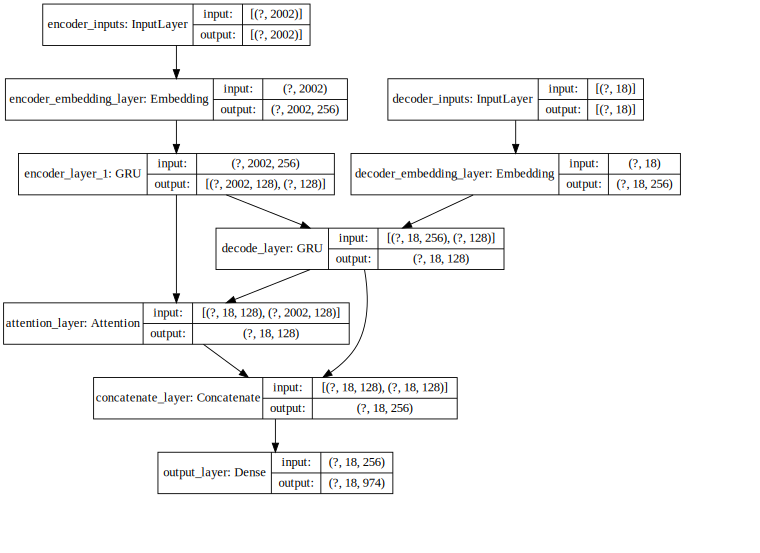

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Attention, Concatenate, Dense
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

# Encoder Input
encoder_inputs = Input(shape=(max_body_morphemes,), name='encoder_inputs')

# Encoder Embedding Layer
encoder_embedding = Embedding(
    num_of_morphemes, 
    embedding_dim, 
    name='encoder_embedding_layer'
)(encoder_inputs)

# Encoder Layer
encoder_outputs, encoder_states = None, None
for i in range(encoder_layer_size):
    encoder_layer = GRU(
        units=hidden_size,
        return_sequences=True, return_state=True,
        dropout=dropout, recurrent_dropout=dropout,
        name='encoder_layer_' + str(i + 1)
    )
    encoder_outputs, encoder_states = encoder_layer(
        encoder_embedding if encoder_outputs is None else encoder_outputs
    )

# Decoder
decoder_inputs = Input(shape=(max_title_morphemes - 1,), name='decoder_inputs')

# Decoder Embedding Layer
decoder_embedding_layer = Embedding(
    num_of_morphemes, 
    embedding_dim, 
    name='decoder_embedding_layer'
)
decoder_embedding = decoder_embedding_layer(decoder_inputs)

# Decoder Layer
decoder_layer = GRU(
    hidden_size,
    return_sequences=True,
    dropout=dropout, recurrent_dropout=dropout / 2,
    name='decode_layer'
)
decoder_outputs = decoder_layer(
    decoder_embedding,
    initial_state=encoder_states
)

# Attention Layer
attention_layer = Attention(name='attention_layer')
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])

# Concatenate the Result of Attention and the Hidden States of Decoder
decoder_concat_inputs = Concatenate(axis=-1, name='concatenate_layer')(
    [decoder_outputs, attention_outputs]
)

# Output Layer
output_layer = Dense(num_of_morphemes, activation=softmax, name='output_layer')
outputs = output_layer(decoder_concat_inputs)

# Define Model
model = Model(
    inputs=[encoder_inputs, decoder_inputs], 
    outputs=outputs,
    name='training_model'
)

# Compile
model.compile(
    optimizer=Adam(learning_rate=learning_late),
    loss=sparse_categorical_crossentropy
)

# Display Model Summary
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

# You need to install graphviz! (sudo apt install graphviz or brew install graphviz)
SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    bodies, titles, test_size=0.2
)
print(x_train)
print(x_test)
print(y_train)
print(y_test)

[[ 69  49   2 ...   0   0   0]
 [ 69 143   9 ...   0   0   0]]
[[ 69  75 119 ...   4   3  70]]
[[ 69  49  33 142  83   8 339  84   4  85   1 340  33 194 104  86 195 196
   70]
 [ 69  88  42  13 106 199 107 143 144  71  36 345  55  70   0   0   0   0
    0]]
[[ 69   2 105 341  87 194 197 198  39 342  47  16 343 344  40  70   0   0
    0]]


In [13]:
history = model.fit(
    [x_train, y_train[:, :-1]], y_train[:, 1:],
    epochs=epochs, batch_size=batch_size,
    validation_data=([x_test, y_test[:, :-1]], y_test[:, 1:])
)

Train on 2 samples, validate on 1 samples
Epoch 1/5
2/2 [==============================] - 7s 3s/sample - loss: 6.8737 - val_loss: 6.8743
Epoch 2/5
2/2 [==============================] - 3s 2s/sample - loss: 6.8501 - val_loss: 6.8666
Epoch 3/5
2/2 [==============================] - 3s 2s/sample - loss: 6.8173 - val_loss: 6.8588
Epoch 4/5
2/2 [==============================] - 4s 2s/sample - loss: 6.7679 - val_loss: 6.8485
Epoch 5/5
2/2 [==============================] - 3s 2s/sample - loss: 6.7148 - val_loss: 6.8351


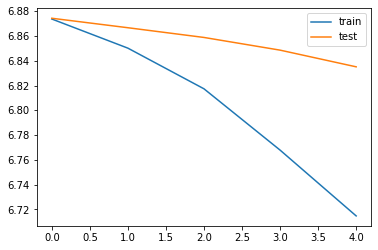

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

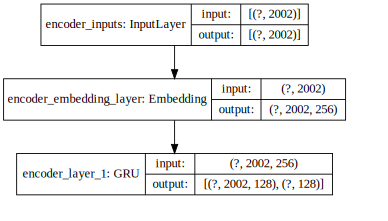

In [15]:
# Define Encoder Model
encoder_model = Model(
    inputs=encoder_inputs,
    outputs=[encoder_outputs, encoder_states],
    name='encoder_model'
)

# You need to install graphviz! (sudo apt install graphviz or brew install graphviz)
SVG(model_to_dot(encoder_model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

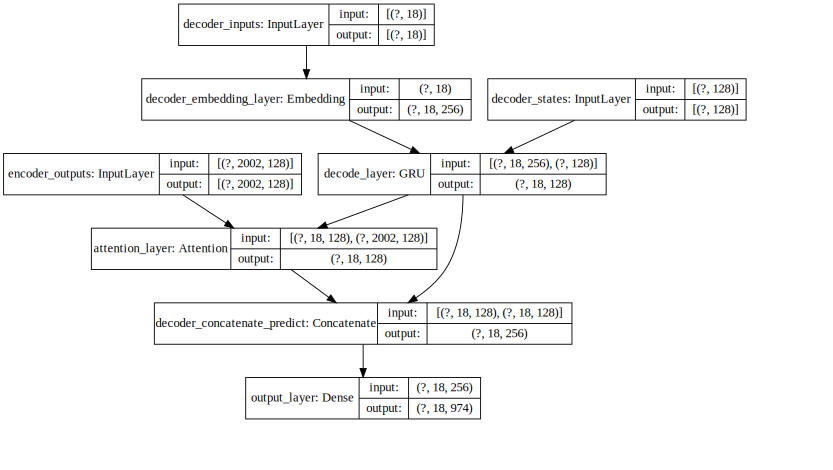

In [18]:
# Decoder
decoder_states_input = Input(
    shape=(hidden_size,),
    name='decoder_states'
)

decoder_embedding_predict = decoder_embedding_layer(decoder_inputs)
decoder_outputs_predict = decoder_layer(
    decoder_embedding_predict,
    initial_state=decoder_states_input
)

# Attention
decoder_hidden_states_input = Input(
    shape=(max_body_morphemes, hidden_size), 
    name='encoder_outputs'
)
attention_outputs_predict = attention_layer(
    [decoder_outputs_predict, decoder_hidden_states_input]
)
decoder_concat_predict = Concatenate(axis=-1, name='decoder_concatenate_predict')(
    [decoder_outputs_predict, attention_outputs_predict]
)

# Output Layer
outputs_predict = output_layer(decoder_concat_predict)

# Define Decoder Model
decoder_model = Model(
    [decoder_inputs, decoder_hidden_states_input, decoder_states_input],
    outputs_predict,
    name='decoder_model'
)

# You need to install graphviz! (sudo apt install graphviz or brew install graphviz)
SVG(model_to_dot(decoder_model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [17]:
def encoding(text: str) -> np.ndarray:
    separated = k.get_morphes_by_tags(text)
    tokenized = tokenizer.texts_to_sequences([separated])[0]
    sequence = np.array([padding(tokenized, max_body_morphemes)])
    return sequence

def predict(body: str) -> Tuple[str, List[Union[int, str]]]:
    input_seq = encoding(body)
    e_out, e_h = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, max_title_morphemes - 1))
    target_seq[0, 0] = tokenizer.word_index[SOT]

    decoded_sentence = ''
    decoded_list: List[Union[int, str]] = []
    len_sentence = 0
    while True:
        output_tokens = decoder_model.predict(
            [target_seq, e_out, e_h]
        )

        sampled_token_index = np.argmax(output_tokens[0, len_sentence, :])
        sampled_token = tokenizer.index_word[sampled_token_index]

        if sampled_token == EOT:
            break
        else:
            if sampled_token != PAD:
                decoded_sentence += ' ' + sampled_token
            decoded_list.append(sampled_token)
            len_sentence += 1

        if len_sentence >= max_title_morphemes - 1:
            break

        target_seq[0, len_sentence] = sampled_token_index

    return decoded_sentence, decoded_list

result = [predict(body) for body in articles['body']]
for i, (title, arr) in enumerate(result):
    print('%-3d answer: \t' % i + articles['title'][i][4:-4])
    print('    predict: \t' + title)
    print('             \t' + str(arr))


0   answer: 	제주항공 "열흘내에 선행조건 다 해결해라"…사실상 파기수순
    predict: 	
             	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1   answer: 	이 앱 열면…한국 10대들 개인정보 중국으로 줄줄 샌다
    predict: 	
             	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2   answer: 	“예수가 레즈비언?” 마이클 잭슨 딸 출연 영화 신성모독 논란
    predict: 	
             	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
